# MNIST handwritten digit classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 


## Import Libraries

In [108]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt


In [2]:
# setting GPU or CPU
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.2.1+cpu
No GPU found, using CPU instead.


## Loading Data

In [3]:
batch_size = 64
epochs = 10
slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_dir = ./data


The data loaders provide a way of iterating (making a loop over) the datasets, each time getting a new batch of data with the given batch size.

The first element of the data batch (`data`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels, where the first value is the number of color channels (only 1 in this case as it's gray scale).

The second element of the batch (`target`) is a vector containing the correct (or "target") classes ("0", "1", ..., "9") for each training digit.

In [4]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([64, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([64]) type: torch.LongTensor


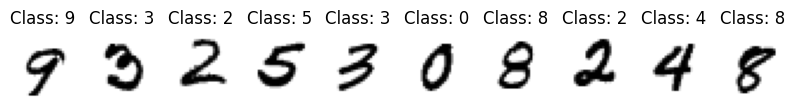

In [5]:
# Here are the first 10 training digits:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

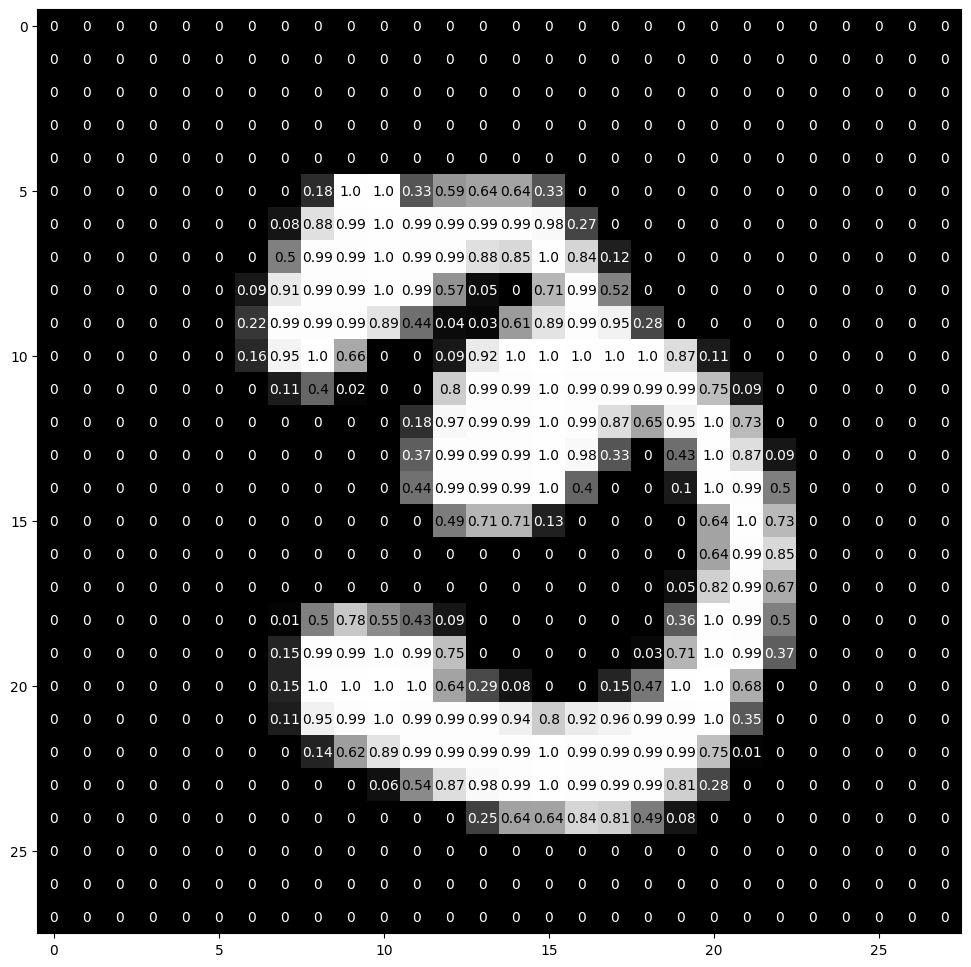

In [6]:
img = np.squeeze(data.numpy()[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Multi-layer perceptron (MLP) network

In PyTorch, a neural network is defined as a Python class. It needs to have two methods:

- `__init__()` which initializes the layers used in the network
- `forward()` which defines how the network performs a forward pass

PyTorch will then automatically generate a `backward()` method that computes the gradients based on the computation done in the forward pass.

In [7]:
# MNIST images are 28x28 pixels
input_nodes = 28 * 28  

# Since there are 10 classes (digits 0-9)
output_nodes = 10  

print('input_nodes:', input_nodes)
print('output_nodes:', output_nodes)


input_nodes: 784
output_nodes: 10


In [8]:
# define the NN architecture
class MLP_Simple(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size , 
        active_func
    ):
        super(MLP_Simple, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        # Activation Function is Relu
        self.af = active_func
        self.softmax = nn.LogSoftmax(dim=1)



    def forward(self, x):
        # flatten image input
        x = x.view(x.size(0), -1)
        # add hidden layer, with activation function
        x = self.af(self.fc1(x))
        # add hidden layer, with activation function
        x =self.af(self.fc2(x))
        # add output layer
        x = self.fc3(x)
        return x

model = MLP_Simple(
    input_size=input_nodes,
    hidden_size1=512,
    hidden_size2=256,
    output_size=output_nodes,
    active_func=torch.relu,
)

print(model)


MLP_Simple(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


## Training the model

In order to train the model we need to define a loss function and an optimizer.

For a classification task we typically use the cross entropy loss. For this we can use the class [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

**Note:** if you read the documentation of `CrossEntropyLoss` carefully you will see that it expects the unnormalized raw outputs of the model as softmax is included implicitly in PyTorch's implementation of `CrossEntropyLoss`. This is why we don't need to explicitly use softmax in the network definition above.

Finally, we need to define an optimizer, which tells how to update the model parameters based on the computed gradients. There are [several different optimizer algorithms implemented in PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms).

In [9]:
# a helper function to calculate the number of correctly classified digits.
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones


In [10]:
# a single training epoch.
def train(data_loader, model, criterion, optimizer):  
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        
        # Do a forward pass
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
    
    return train_loss,accuracy



In [11]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)
        
            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
        
            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")
    
    return test_loss , accuracy

In [94]:
def evaluation_plot(results):
    plt.figure(figsize=(10, 5))
    for name, (losses, _) in results.items():
        plt.plot(losses, label=name)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Compare Optimizations

In [61]:
criterion = nn.CrossEntropyLoss()

optimizer_arr = [ "SGD" , "Adam" , "Adagrad"  , "RAdam"]

In [132]:
# train and evaluation of  optimizer funcs
results = {}
epochs = 10

for name in optimizer_arr:
    print(f"\nTraining with {name} optimizer:")
    
    model = MLP_Simple(
        input_size=input_nodes,
        hidden_size1=512,
        hidden_size2=512,
        output_size=output_nodes,
        active_func=torch.relu)
    
    optimizers = {
        "SGD": torch.optim.SGD(model.parameters(), lr=0.001),
        "Adam":  torch.optim.Adam(model.parameters() , lr=0.001),
        "Adagrad" : torch.optim.Adagrad(model.parameters(), lr=0.001),
        "RAdam": torch.optim.RAdam(model.parameters(), lr=0.001)
        }
    
    optimizer = optimizers[name]

    losses = []
    for epoch in range(epochs):
        print(f"Training epoch: {epoch+1}")
        loss , _ = train(train_loader, model, criterion, optimizer)
        losses.append(loss.detach().numpy())

    accuracy = test(test_loader , model , criterion )
    results[name] = (losses, accuracy)


Training with SGD optimizer:
Training epoch: 1
Average loss: 2.285046, accuracy: 25.54%
Training epoch: 2
Average loss: 2.236006, accuracy: 55.04%
Training epoch: 3
Average loss: 2.159428, accuracy: 68.00%
Training epoch: 4
Average loss: 2.023793, accuracy: 71.32%
Training epoch: 5
Average loss: 1.791469, accuracy: 72.34%
Training epoch: 6
Average loss: 1.474653, accuracy: 73.89%
Training epoch: 7
Average loss: 1.171912, accuracy: 76.93%
Training epoch: 8
Average loss: 0.951949, accuracy: 79.94%
Training epoch: 9
Average loss: 0.805790, accuracy: 81.95%
Training epoch: 10
Average loss: 0.706793, accuracy: 83.23%
Testset accuracy: 84.0%, average loss: 0.647630

Training with Adam optimizer:
Training epoch: 1
Average loss: 0.226292, accuracy: 93.14%
Training epoch: 2
Average loss: 0.083290, accuracy: 97.35%
Training epoch: 3
Average loss: 0.054352, accuracy: 98.26%
Training epoch: 4
Average loss: 0.042473, accuracy: 98.66%
Training epoch: 5
Average loss: 0.031157, accuracy: 98.98%
Train

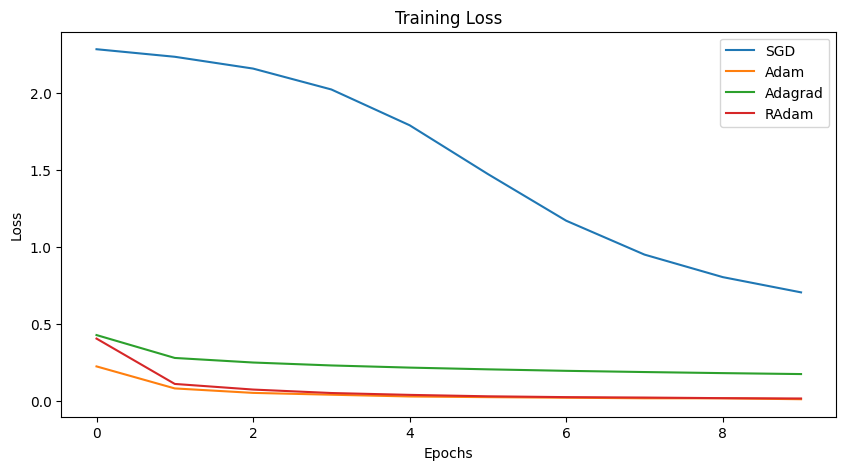

In [133]:
evaluation_plot(results)

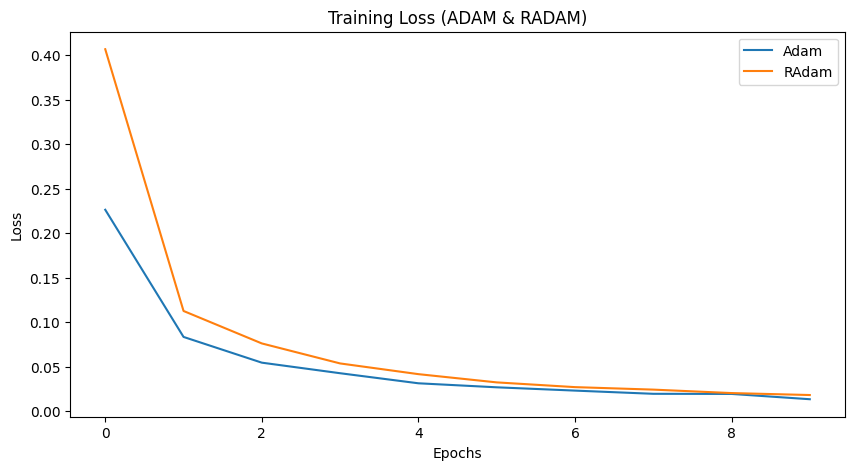

In [134]:
plt.figure(figsize=(10, 5))
plt.plot(results["Adam"][0], label="Adam")
plt.plot(results["RAdam"][0], label="RAdam")
plt.title('Training Loss (ADAM & RADAM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

`Adam` Optimizer is the best

## Compare Activation Functions


In [86]:
criterion = nn.CrossEntropyLoss()

activations = {
    "Sigmoid": nn.Sigmoid(),
    "ReLU":  nn.ReLU(),
    "LeakyReLU" : nn.LeakyReLU(0.01),
    "Softmax": nn.Softmax(dim=1) ,
    "Tanh" : nn.Tanh() ,
    "ELU" : nn.ELU()
    }

In [92]:


# train and evaluation of  optimizer funcs
results = {}
epochs = 10

for name  , activation in activations.items():
    print(f"\nTraining with {name} Activation Function:")
    
    model = MLP_Simple(
        input_size=input_nodes,
        hidden_size1=512,
        hidden_size2=512,
        output_size=output_nodes,
        active_func=activation)
    
    optimizer = torch.optim.Adam(model.parameters() , lr=0.001)

    losses = []
    for epoch in range(epochs):
        print(f"Training epoch: {epoch+1}")
        loss , _ = train(train_loader, model, criterion, optimizer)
        losses.append(loss.detach().numpy())

    accuracy = test(test_loader , model , criterion )
    results[name] = (losses, accuracy)


Training with Sigmoid optimizer:
Training epoch: 1
Average loss: 0.427838, accuracy: 87.28%
Training epoch: 2
Average loss: 0.166859, accuracy: 94.88%
Training epoch: 3
Average loss: 0.112101, accuracy: 96.59%
Training epoch: 4
Average loss: 0.082219, accuracy: 97.49%
Training epoch: 5
Average loss: 0.061198, accuracy: 98.10%
Training epoch: 6
Average loss: 0.046851, accuracy: 98.56%
Training epoch: 7
Average loss: 0.035539, accuracy: 98.82%
Training epoch: 8
Average loss: 0.027252, accuracy: 99.11%
Training epoch: 9
Average loss: 0.022683, accuracy: 99.28%
Training epoch: 10
Average loss: 0.018508, accuracy: 99.38%
Testset accuracy: 97.7%, average loss: 0.085438

Training with ReLU optimizer:
Training epoch: 1
Average loss: 0.219870, accuracy: 93.52%
Training epoch: 2
Average loss: 0.086263, accuracy: 97.35%
Training epoch: 3
Average loss: 0.057219, accuracy: 98.18%
Training epoch: 4
Average loss: 0.041882, accuracy: 98.66%
Training epoch: 5
Average loss: 0.032335, accuracy: 98.92%
T

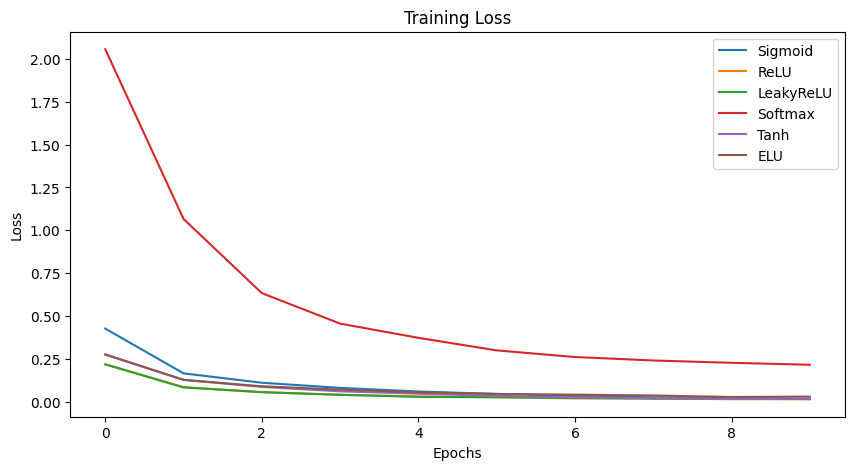

In [95]:
evaluation_plot(results)

`ReLU` & `LeakyReLU` is the best

## Using Dropout

In [104]:
# define the NN architecture
class MLP(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size,
        dropout_rate,
        active_func,
    ):
        super(MLP, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(input_size, hidden_size1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(dropout_rate)
        # Activation Function
        self.af = active_func


    def forward(self, x):
        # flatten image input
        x = x.view(x.size(0) ,-1)
        # add hidden layer, with activation function
        x = self.af(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with activation function
        x =self.af(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


In [105]:
criterion = nn.CrossEntropyLoss()

dropoutRates = [0.1, 0.3, 0.5, 0.7, 0.9]


In [107]:
# train and evaluation of  optimizer funcs
results = {}
epochs = 10

for rate in dropoutRates:
    print(f"\nTraining with {rate} Dropout rate:")
    
    model = MLP(
        input_size=input_nodes,
        hidden_size1=512,
        hidden_size2=512,
        output_size=output_nodes,
        dropout_rate= rate,
        active_func=nn.ReLU())
    
    optimizer = torch.optim.Adam(model.parameters() , lr=0.001)

    losses = []
    for epoch in range(epochs):
        print(f"Training epoch: {epoch+1}")
        loss , _ = train(train_loader, model, criterion, optimizer)
        losses.append(loss.detach().numpy())

    accuracy = test(test_loader , model , criterion )
    results[rate] = (losses, accuracy)


Training with 0.1 Dropout rate:
Training epoch: 1
Average loss: 0.232358, accuracy: 93.03%
Training epoch: 2
Average loss: 0.093887, accuracy: 97.10%
Training epoch: 3
Average loss: 0.065761, accuracy: 97.99%
Training epoch: 4
Average loss: 0.050267, accuracy: 98.35%
Training epoch: 5
Average loss: 0.042164, accuracy: 98.61%
Training epoch: 6
Average loss: 0.034513, accuracy: 98.86%
Training epoch: 7
Average loss: 0.028728, accuracy: 99.06%
Training epoch: 8
Average loss: 0.026937, accuracy: 99.13%
Training epoch: 9
Average loss: 0.023056, accuracy: 99.25%
Training epoch: 10
Average loss: 0.022654, accuracy: 99.24%
Testset accuracy: 98.2%, average loss: 0.087586

Training with 0.3 Dropout rate:
Training epoch: 1
Average loss: 0.266623, accuracy: 91.85%
Training epoch: 2
Average loss: 0.117913, accuracy: 96.36%
Training epoch: 3
Average loss: 0.088087, accuracy: 97.23%
Training epoch: 4
Average loss: 0.074213, accuracy: 97.64%
Training epoch: 5
Average loss: 0.062304, accuracy: 98.01%


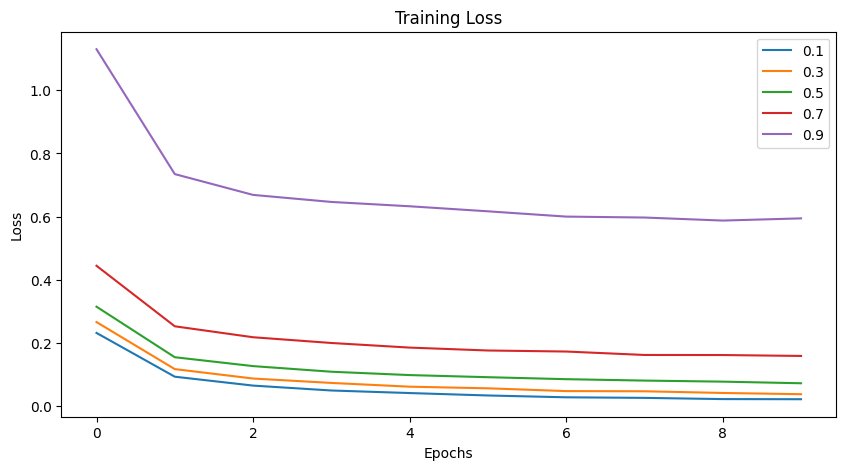

In [109]:
evaluation_plot(results)

Dropout rate `0.1` is the best

## Data Augmentation

In [110]:
batch_size = 64
epochs = 10

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])


slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_dir, train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_dir = ./data


In [113]:
results = {}
epochs = 10

model = MLP(
    input_size=input_nodes,
    hidden_size1=512,
    hidden_size2=512,
    output_size=output_nodes,
    dropout_rate= 0.1,
    active_func=nn.ReLU())

optimizer = torch.optim.Adam(model.parameters() , lr=0.001)
losses = []
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    loss , _ = train(train_loader, model, criterion, optimizer)
    losses.append(loss.detach().numpy())
accuracy = test(test_loader , model , criterion )
results["Data Augmented"] = (losses, accuracy)

Training epoch: 1
Average loss: 0.476719, accuracy: 84.23%
Training epoch: 2
Average loss: 0.280218, accuracy: 91.14%
Training epoch: 3
Average loss: 0.226418, accuracy: 92.73%
Training epoch: 4
Average loss: 0.204833, accuracy: 93.56%
Training epoch: 5
Average loss: 0.184939, accuracy: 93.98%
Training epoch: 6
Average loss: 0.171429, accuracy: 94.54%
Training epoch: 7
Average loss: 0.161575, accuracy: 94.80%
Training epoch: 8
Average loss: 0.152576, accuracy: 95.17%
Training epoch: 9
Average loss: 0.148367, accuracy: 95.30%
Training epoch: 10
Average loss: 0.137740, accuracy: 95.60%
Testset accuracy: 96.4%, average loss: 0.123536


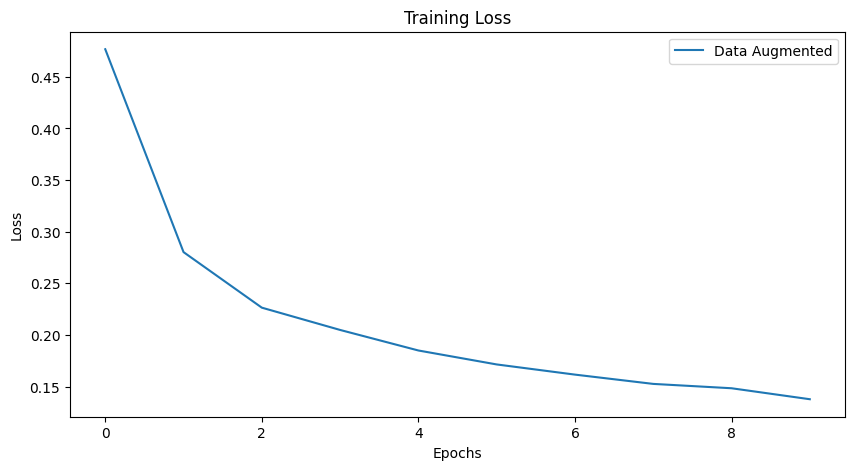

In [114]:
evaluation_plot(results)

## Compare Batⅽh (128 , 16)

In [115]:
batch_size = 64
epochs = 10
slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_dir = ./data


In [137]:
criterion = nn.CrossEntropyLoss()

epochs_arr = [16 , 128]


In [138]:
results = {}

for epochs in epochs_arr:
    print(f"\nTraining with {epoch} Epochs:")
    
    model = MLP(
        input_size=input_nodes,
        hidden_size1=512,
        hidden_size2=512,
        output_size=output_nodes,
        dropout_rate= 0.1,
        active_func=nn.ReLU())
    
    optimizer = torch.optim.Adam(model.parameters() , lr=0.001)

    losses = []
    for epoch in range(epochs):
        print(f"Training epoch: {epoch+1}")
        loss , _ = train(train_loader, model, criterion, optimizer)
        losses.append(loss.detach().numpy())

    accuracy = test(test_loader , model , criterion )
    results[epoch] = (losses, accuracy)


Training with 9 Epochs:
Training epoch: 1
Average loss: 0.233931, accuracy: 92.86%
Training epoch: 2
Average loss: 0.094936, accuracy: 96.99%
Training epoch: 3
Average loss: 0.067597, accuracy: 97.86%
Training epoch: 4
Average loss: 0.050661, accuracy: 98.45%
Training epoch: 5
Average loss: 0.042901, accuracy: 98.65%
Training epoch: 6
Average loss: 0.036220, accuracy: 98.80%
Training epoch: 7
Average loss: 0.029949, accuracy: 99.03%
Training epoch: 8
Average loss: 0.028050, accuracy: 99.04%
Training epoch: 9
Average loss: 0.023879, accuracy: 99.20%
Training epoch: 10
Average loss: 0.021557, accuracy: 99.27%
Training epoch: 11
Average loss: 0.020829, accuracy: 99.34%
Training epoch: 12
Average loss: 0.017238, accuracy: 99.41%
Training epoch: 13
Average loss: 0.018888, accuracy: 99.38%
Training epoch: 14
Average loss: 0.017911, accuracy: 99.40%
Training epoch: 15
Average loss: 0.015840, accuracy: 99.52%
Training epoch: 16
Average loss: 0.015653, accuracy: 99.53%
Testset accuracy: 98.1%,

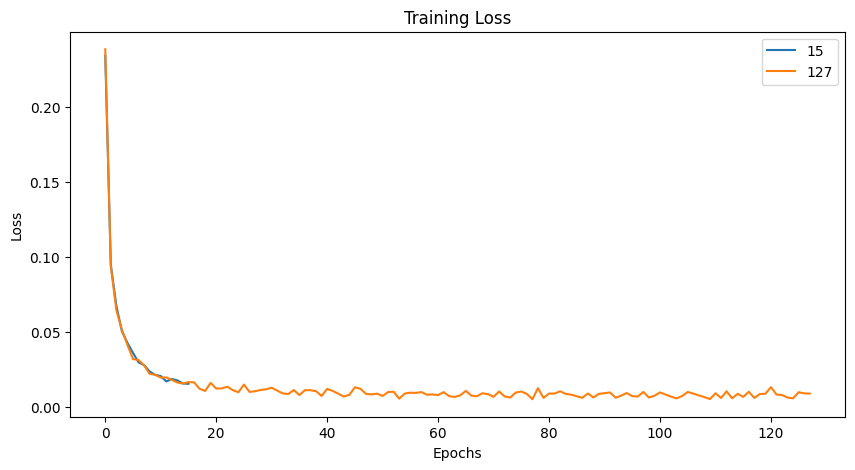

In [139]:
evaluation_plot(results)

## Batch Normalization with Sigmoid

In [129]:
# define the NN architecture
class MLP_4Layer(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        hidden_size4,
        output_size,
        dropout_rate,
        active_func,
    ):
        super(MLP_4Layer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.af = active_func


    def forward(self, x):
        # flatten image input
        x = x.view(x.size(0) ,-1)

        x = self.af(self.fc1(x))
        x = self.dropout(x)

        x =self.af(self.fc2(x))
        x = self.dropout(x)

        x =self.af(self.fc3(x))
        x = self.dropout(x)

        x =self.af(self.fc4(x))
        x = self.dropout(x)

        x = self.fc5(x)
        return x


In [130]:
# define the NN architecture
class MLP_WithBatchNorm(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        hidden_size4,
        output_size,
        dropout_rate,
        active_func,
    ):
        super(MLP_WithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.af = active_func


    def forward(self, x):
        # flatten image input
        x = x.view(x.size(0) ,-1)

        x = self.bn1(self.fc1(x))
        x = self.af(x)
        x = self.dropout(x)

        x = self.bn2(self.fc2(x))
        x =self.af(x)
        x = self.dropout(x)

        x = self.bn3(self.fc3(x))
        x =self.af(x)
        x = self.dropout(x)

        x = self.bn4(self.fc4(x))
        x =self.af(x)
        x = self.dropout(x)

        x = self.fc5(x)
        return x


In [135]:
results = {}
epochs = 10


## Without Batch Normilization(-)  4 layer 

print(f"\nTraining with MLP Without Batch Normilization:")

model = MLP(
    input_size=input_nodes,
    hidden_size1=512,
    hidden_size2=512,
    output_size=output_nodes,
    dropout_rate= 0.1,
    active_func=nn.Sigmoid())

optimizer = torch.optim.Adam(model.parameters() , lr=0.001)
losses = []
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    loss , _ = train(train_loader, model, criterion, optimizer)
    losses.append(loss.detach().numpy())
accuracy = test(test_loader , model , criterion )
results["Without Batch Normilization(-) 4 layer"] = (losses, accuracy)


## With Batch Normilization(+)

print(f"\nTraining with MLP With Batch Normilization:")

model = MLP_WithBatchNorm(
    input_size=input_nodes,
    hidden_size1=512,
    hidden_size2=512,
    hidden_size3=512,
    hidden_size4=512,
    output_size=output_nodes,
    dropout_rate= 0.1,
    active_func=nn.Sigmoid())

optimizer = torch.optim.Adam(model.parameters() , lr=0.001)
losses = []
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    loss , _ = train(train_loader, model, criterion, optimizer)
    losses.append(loss.detach().numpy())
accuracy = test(test_loader , model , criterion )
results["With Batch Normilization(+) 4 layer"] = (losses, accuracy)



Training with MLP Without Batch Normilization:
Training epoch: 1
Average loss: 0.441436, accuracy: 86.56%
Training epoch: 2
Average loss: 0.176979, accuracy: 94.67%
Training epoch: 3
Average loss: 0.123242, accuracy: 96.22%
Training epoch: 4
Average loss: 0.090440, accuracy: 97.22%
Training epoch: 5
Average loss: 0.070653, accuracy: 97.73%
Training epoch: 6
Average loss: 0.058286, accuracy: 98.13%
Training epoch: 7
Average loss: 0.046123, accuracy: 98.53%
Training epoch: 8
Average loss: 0.037774, accuracy: 98.80%
Training epoch: 9
Average loss: 0.031172, accuracy: 99.03%
Training epoch: 10
Average loss: 0.025929, accuracy: 99.14%
Testset accuracy: 98.2%, average loss: 0.067463

Training with MLP With Batch Normilization:
Training epoch: 1
Average loss: 0.425168, accuracy: 87.81%
Training epoch: 2
Average loss: 0.278683, accuracy: 91.52%
Training epoch: 3
Average loss: 0.228143, accuracy: 93.15%
Training epoch: 4
Average loss: 0.189426, accuracy: 94.03%
Training epoch: 5
Average loss: 

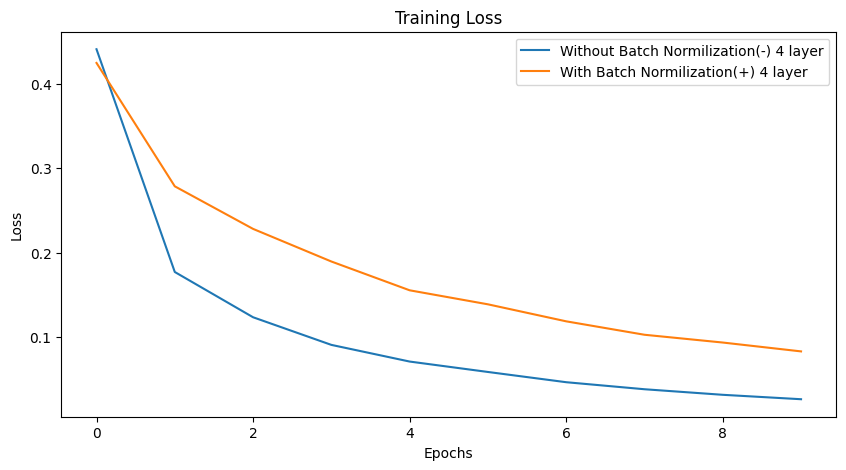

In [136]:
evaluation_plot(results)